# Adam + LBFGS

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time
import os

Using device: cpu
Solving ODE...
ODE solve time: 0.0082 seconds
Training PINN...
[Adam] Epoch 0, Loss: 2.341e+03
[Adam] Epoch 1000, Loss: 3.381e+01
[Adam] Epoch 2000, Loss: 2.812e+01
[Adam] Epoch 3000, Loss: 1.981e+01
[Adam] Epoch 4000, Loss: 1.774e+01
[Adam] Epoch 5000, Loss: 1.684e+01
[Adam] Epoch 6000, Loss: 1.647e+01
[Adam] Epoch 7000, Loss: 1.475e+01
[Adam] Epoch 8000, Loss: 1.418e+01
[Adam] Epoch 9000, Loss: 1.356e+01
PINN training time: 64.71 seconds
Starting LBFGS optimization...
LBFGS optimization time: 17.50 seconds


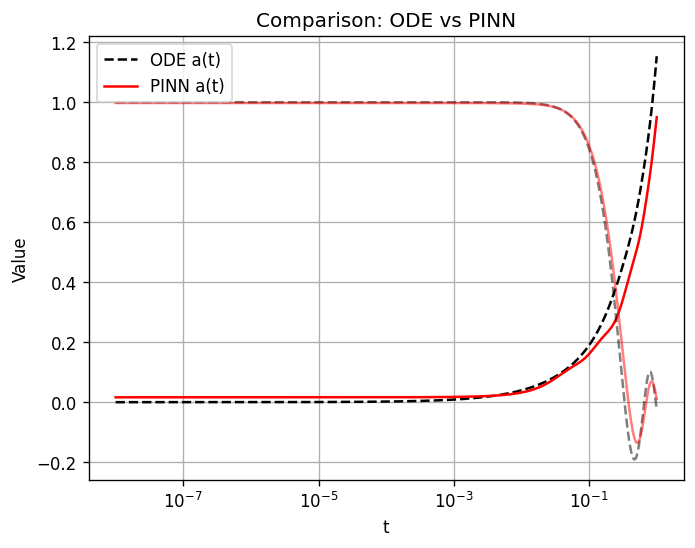

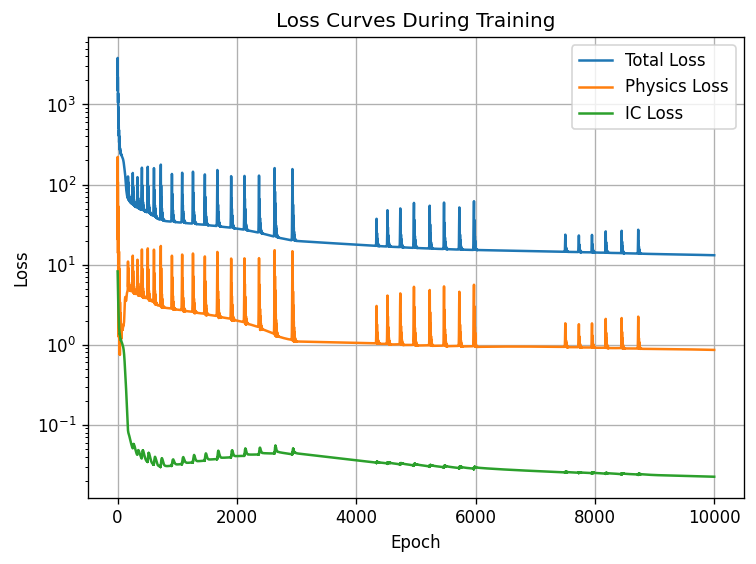

In [9]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time
import os

# --- Define PINN ---
class PINN(nn.Module):
    def __init__(self, num_layers, num_neurons, N_fields):
        super(PINN, self).__init__()
        self.N_fields = N_fields
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(1, num_neurons))
        for _ in range(num_layers):
            self.layers.append(nn.Linear(num_neurons, num_neurons))
        self.layers.append(nn.Linear(num_neurons, 1 + N_fields))

    def forward(self, t):
        x = t
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        x = self.layers[-1](x)
        a = torch.nn.functional.softplus(x[:, 0:1])
        a = torch.clamp(a, min=1e-6)
        phi = x[:, 1:]
        return a, phi

# --- Define ODE system ---
def ode_system(t, y, m_vec, rho_m0, rho_r0, rho_l0):
    N = len(m_vec)
    a = y[0]
    phi = y[1:N+1]
    phi_dot = y[N+1:2*N+1]

    kinetic = 0.5 * np.sum((phi_dot * a)**2)
    potential = 0.5 * np.sum((m_vec**2) * (phi * a)**2)

    H = np.sqrt((1/3) * (kinetic + potential + rho_m0 / a + rho_r0 / a**2 + rho_l0 * a**2))
    a_dot = H
    phi_ddot = - np.sqrt(3) * np.sqrt(
        0.5 * np.sum(phi_dot**2) +
        0.5 * np.sum((m_vec**2) * phi**2) +
        rho_m0 / a**3 + rho_r0 / a**4 + rho_l0
    ) * phi_dot - (m_vec**2) * phi

    dydt = np.zeros_like(y)
    dydt[0] = a_dot
    dydt[1:N+1] = phi_dot
    dydt[N+1:2*N+1] = phi_ddot
    return dydt

# --- Settings ---
###################
###################

device = torch.device('cpu')
print(f"Using device: {device}")

N_fields = 1
#m_vec = np.linspace(1.0, 50.0, N_fields)
m_vec = np.array([10.0])
rho_m0 = 0.81
rho_r0 = 0.00027138
rho_l0 = 2.19

phi0_np = np.array([1.0]*N_fields)
phi_dot0_np = np.array([0.0]*N_fields)
a0_np = 1e-8
y0 = np.concatenate([[a0_np], phi0_np, phi_dot0_np])

t_span = (0.0, 1.0)
t_eval = np.logspace(-8, 0, 1000).astype(np.float32)

# --- Solve ODE ---
print("Solving ODE...")
start_ode = time.time()
sol = solve_ivp(ode_system, t_span, y0, t_eval=t_eval, args=(m_vec, rho_m0, rho_r0, rho_l0), method='RK45')
end_ode = time.time()
ode_time = end_ode - start_ode
print(f"ODE solve time: {ode_time:.4f} seconds")

a_sol = sol.y[0, :]
phi_sol = sol.y[1:1+N_fields, :]

# --- Train PINN ---
model = PINN(num_layers=1, num_neurons=100, N_fields=N_fields).to(device)
m_vec_torch = torch.tensor(m_vec, dtype=torch.float32, device=device)
phi0 = torch.tensor(phi0_np.reshape(1, -1), device=device)
a0 = torch.tensor([[a0_np]], device=device)
t0 = torch.tensor([[0.0]], device=device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.5)

N_f = 1000
max_epochs_adam = 10000
physics_weight = 10.0
ic_weight = 200.0
a_weight = 10.0
phi_weight = 1

# --- Define losses ---
def physics_loss(model, t):
    a, phi = model(t)
    a_t = torch.autograd.grad(a, t, grad_outputs=torch.ones_like(a), create_graph=True)[0]
    phi_t = torch.autograd.grad(phi, t, grad_outputs=torch.ones_like(phi), create_graph=True)[0]
    phi_tt = torch.autograd.grad(phi_t, t, grad_outputs=torch.ones_like(phi_t), create_graph=True)[0]

    kinetic = 0.5 * torch.sum((phi_t**2) * (a**2), dim=1, keepdim=True)
    potential = 0.5 * torch.sum((m_vec_torch**2) * (phi**2) * (a**2), dim=1, keepdim=True)
    Friedmann = a_t - torch.sqrt((1/3)*(kinetic + potential + rho_m0/a + rho_r0/a**2 + rho_l0 * a**2) + 1e-12)

    sqsumrho = torch.sqrt(torch.full_like(t, 3.0)) * torch.sqrt(
        0.5 * torch.sum(phi_t**2, dim=1, keepdim=True) +
        0.5 * torch.sum((m_vec_torch**2) * phi**2, dim=1, keepdim=True) +
        rho_m0/a**3 + rho_r0/a**4 + rho_l0 + 1e-12
    )
    KG = phi_tt + sqsumrho * phi_t + phi * (m_vec_torch**2)

    return torch.mean(Friedmann**2) + torch.mean(KG**2)

def initial_loss(model):
    a_pred0, phi_pred0 = model(t0)
    return a_weight * torch.mean((a_pred0 - a0)**2) + phi_weight * torch.mean((phi_pred0 - phi0)**2)

# --- Train with Adam ---
print("Training PINN...")
start_train = time.time()

loss_history = []
physics_loss_history = []
ic_loss_history = []

for epoch in range(max_epochs_adam):
    t_f = torch.linspace(0.0, 1.0, N_f, device=device).reshape(-1, 1).requires_grad_()
    optimizer.zero_grad()
    loss_physics_val = physics_loss(model, t_f)
    loss_ic_val = initial_loss(model)
    loss = physics_weight * loss_physics_val + ic_weight * loss_ic_val
    loss.backward()
    optimizer.step()
    scheduler.step()
    loss_history.append(loss.item())
    physics_loss_history.append(loss_physics_val.item())
    ic_loss_history.append(loss_ic_val.item())
    if epoch % 1000 == 0:
        print(f"[Adam] Epoch {epoch}, Loss: {loss.item():.3e}")

end_train = time.time()
pinn_time = end_train - start_train
print(f"PINN training time: {pinn_time:.2f} seconds")

# --- LBFGS optimization ---
print("Starting LBFGS optimization...")

optimizer_lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=5000,
    tolerance_grad=1e-9,
    tolerance_change=1e-9,
    history_size=50,
    line_search_fn='strong_wolfe'
)

def closure():
    optimizer_lbfgs.zero_grad()
    t_f = torch.linspace(0.0, 1.0, N_f, device=device).reshape(-1, 1).requires_grad_()
    loss_physics_val = physics_loss(model, t_f)
    loss_ic_val = initial_loss(model)
    loss = physics_weight * loss_physics_val + ic_weight * loss_ic_val
    loss.backward()
    return loss

start_lbfgs = time.time()
optimizer_lbfgs.step(closure)
end_lbfgs = time.time()

print(f"LBFGS optimization time: {end_lbfgs - start_lbfgs:.2f} seconds")


# --- Evaluate model ---
t_plot = torch.tensor(t_eval, device=device).reshape(-1, 1).requires_grad_(True)
a_pred, phi_pred = model(t_plot)
a_pred = a_pred.detach().cpu().numpy().flatten()
phi_pred = phi_pred.detach().cpu().numpy().T

folder_name = 'csv_m10'

# --- Save data ---
os.makedirs(folder_name, exist_ok=True)
np.savetxt(folder_name+'/t_values.csv', t_eval, delimiter=',')
np.savetxt(folder_name+'/a_ode.csv', a_sol, delimiter=',')
np.savetxt(folder_name+'/a_pinn.csv', a_pred, delimiter=',')
np.savetxt(folder_name+'/phi_ode.csv', phi_sol, delimiter=',')
np.savetxt(folder_name+'/phi_pinn.csv', phi_pred, delimiter=',')

# --- Plot results ---
plt.figure(dpi=120)
plt.plot(t_eval, a_sol, 'k--', label='ODE a(t)')
plt.plot(t_eval, a_pred, 'r-', label='PINN a(t)')
for i in range(min(N_fields, 5)):
    plt.plot(t_eval, phi_sol[i, :], 'k--', alpha=0.5)
    plt.plot(t_eval, phi_pred[i, :], 'r-', alpha=0.5)
plt.xscale('log')
plt.xlabel('t')
plt.ylabel('Value')
plt.title('Comparison: ODE vs PINN')
plt.legend()
plt.grid()
plt.savefig(folder_name+'/comparison.png')
plt.show()

# --- Plot Losses ---
plt.figure(dpi=120)
plt.plot(loss_history, label='Total Loss')
plt.plot(physics_loss_history, label='Physics Loss')
plt.plot(ic_loss_history, label='IC Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves During Training')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(folder_name+'/loss_curves.png')
plt.show()

Make plots

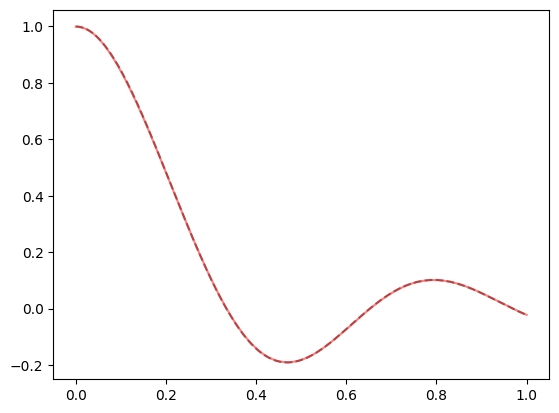

In [8]:
# Load data from folder
folder = 'csv_m10'
t_eval = np.loadtxt(f'{folder}/t_values.csv', delimiter=',')
a_ode = np.loadtxt(f'{folder}/a_ode.csv', delimiter=',')
a_pinn = np.loadtxt(f'{folder}/a_pinn.csv', delimiter=',')
phi_ode = np.loadtxt(f'{folder}/phi_ode.csv', delimiter=',')
phi_pinn = np.loadtxt(f'{folder}/phi_pinn.csv', delimiter=',')

# Make sure phi arrays are 2D (shape: N_fields x len(t))
phi_ode = np.atleast_2d(phi_ode)
phi_pinn = np.atleast_2d(phi_pinn)
N_fields = phi_ode.shape[0]

for i in range(min(N_fields, 5)):  # limit to first few phi fields
    plt.plot(t_eval, phi_ode[i], 'k--', alpha=0.5, label=f'ODE phi_{i}(t)' if i == 0 else "")
    plt.plot(t_eval, phi_pinn[i], 'r-', alpha=0.5, label=f'PINN phi_{i}(t)' if i == 0 else "")

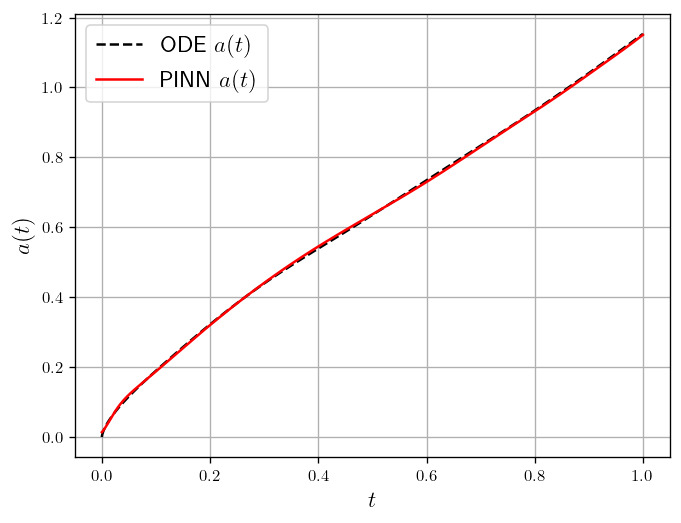

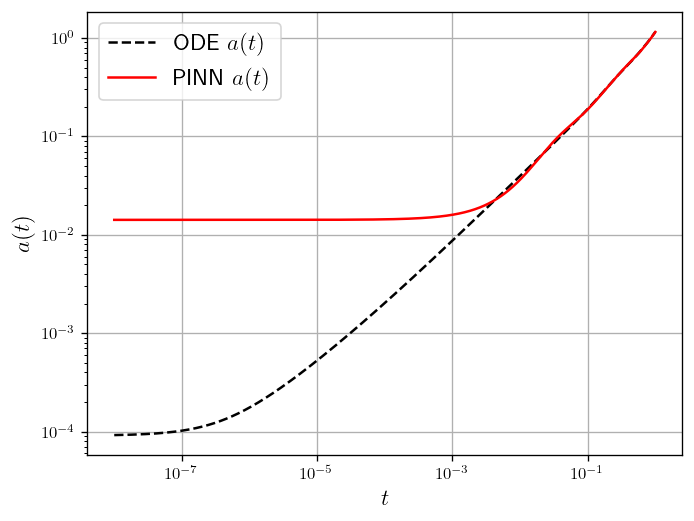

In [28]:
plt.rcParams['mathtext.fontset'] = 'cm' # Example
# plt.rcParams['text.usetex'] = True
# --- Plot results ---
plt.figure(dpi=120)
plt.plot(t_eval, a_sol, 'k--', label=r'ODE $a(t)$')
plt.plot(t_eval, a_pred, 'r-', label=r'PINN $a(t)$')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel(r'$a(t)$', fontsize=14)
# plt.title('Comparison: ODE vs PINN')
plt.legend(loc='upper left', fontsize=14)
plt.grid()
plt.savefig('csv_m10/a_comparison_linear.png')
plt.show()

plt.figure(dpi=120)
plt.plot(t_eval, a_sol, 'k--', label=r'ODE $a(t)$')
plt.plot(t_eval, a_pred, 'r-', label=r'PINN $a(t)$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel(r'$a(t)$', fontsize=14)
# plt.title('Comparison: ODE vs PINN')
plt.legend(loc='upper left', fontsize=14)
plt.grid()
plt.savefig('csv_m10/a_comparison_log.png')
plt.show()


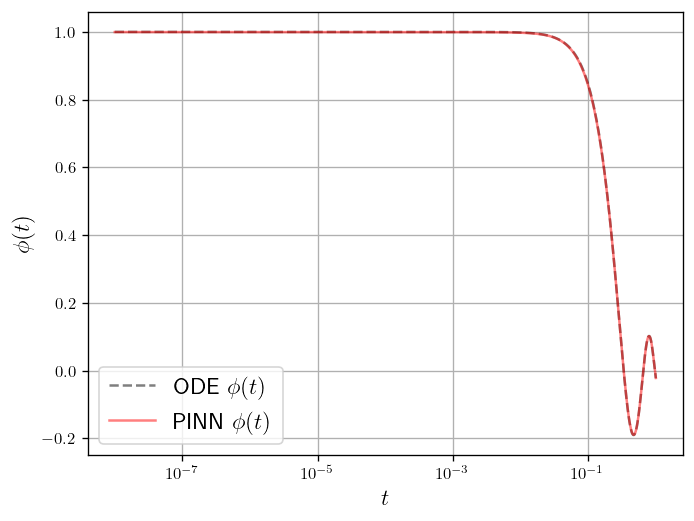

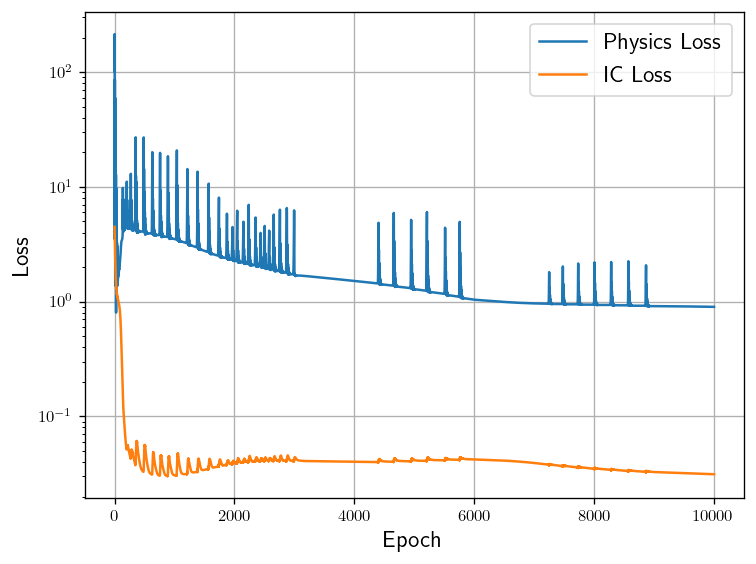

In [35]:

plt.figure(dpi=120)
for i in range(min(N_fields, 5)):
    plt.plot(t_eval, phi_sol[i, :], 'k--', alpha=0.5, label=r'ODE $\phi(t)$')
    plt.plot(t_eval, phi_pred[i, :], 'r-', alpha=0.5, label=r'PINN $\phi(t)$')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel(r'$\phi(t)$', fontsize=14)
# plt.title('Comparison: ODE vs PINN')
plt.legend(loc= 'lower left',fontsize=14)
plt.grid()
plt.savefig('csv_m10/phi_comparison.png')
plt.show()

# --- Plot Losses ---
plt.figure(dpi=120)
# plt.plot(loss_history, label='Total Loss')
plt.plot(physics_loss_history, label='Physics Loss')
plt.plot(ic_loss_history, label='IC Loss')
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
# plt.title('Loss Curves During Training')
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('csv_m10/loss_curves.png')
plt.show()